Prevendo cancelamento de assinatura de TV a Cabo

In [1]:
# Importando Bibliotecas
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split #Utilizada para separar dados pra treino e teste
from sklearn.preprocessing import StandardScaler #Utilizada para fazer a padronização dos dados
from sklearn.preprocessing import LabelEncoder #Utilizada para fazer o OneHotEncoding
from sklearn.metrics import accuracy_score #Utilizada para avaliar a acurácia do modelo preditivo
from sklearn.neighbors import KNeighborsClassifier #Nosso Algoritmo para criação do modelo
from imblearn import under_sampling, over_sampling #Utilizada para fazer o balanceamento de dados
from imblearn.over_sampling import SMOTE #Utilizada para fazer o balanceamento de dados
import warnings #Utilizada para avisos de alertas
warnings.filterwarnings("ignore") #Ignorar avisos de alertas. Obs.: Alertas NÃO são erros, são apenas mensagens informativas
# Para não limitar a exibição do DataFrame
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
# Carregando a base de dados
dados = pd.read_csv("dados.csv", sep = ';')

In [3]:
# Observando
dados.head()

,ID_CLIENTE,FORMA_AQUISICAO,IDADE_CLIENTE,SEXO,QT_FILHOS,DT_AQUISICAO,DT_CANCELAMENTO,DIAS_ATIVO,MESES_ATIVO,DURACAO_CONTRATO,VL_PLANO_ADESAO,VL_PLANO_ATUAL,NOME_PRODUTO,QT_PONTOS_INSTALADOS,QT_PC_PAGAS,QT_PC_VENCIDAS,QT_PC_PAGA_ATRASO,QT_PC_PAGA_EM_DIA,QT_ACORDO_PAGAMENTO,VL_MENSALIDADE_ATRASO,VL_MENSALIDADE_DT_AQUISICAO,VL_MENSALIDADE_DT_ATUAL,SITUACAO,COD_SITUACAO
0,1,Site,23,MASCULINO,0.0,18/06/2021,NaN,33,1,48 Meses,450,518,PLANO FAMILIA (100 CANAIS HD),1,1,4,0,1,1,2070,450,518,ATIVO,0
1,2,Vendedor,24,FEMININO,0.0,10/04/2018,NaN,1198,39,48 Meses,230,265,PLANO BASICO (30 CANAIS HD),2,5,0,1,4,0,0,230,265,ATIVO,0
2,3,Site,25,MASCULINO,0.0,09/10/2020,NaN,285,9,48 Meses,290,334,PLANO BASICO PLUS (50 CANAIS HD),3,5,0,3,2,0,0,290,334,ATIVO,0
3,4,Vendedor,26,FEMININO,17.0,25/06/2019,NaN,757,25,48 Meses,230,265,PLANO BASICO (30 CANAIS HD),1,5,0,1,4,0,0,230,265,ATIVO,0
4,5,Vendedor,27,MASCULINO,0.0,19/09/2019,NaN,671,22,48 Meses,230,265,PLANO BASICO (30 CANAIS HD),2,5,0,5,0,0,0,230,265,ATIVO,0


In [4]:
# Observando o shape
dados.shape

(448447, 24)

In [5]:
# Verificando os tipos de dados das variáveis
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 448447 entries, 0 to 448446
Data columns (total 24 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   ID_CLIENTE                   448447 non-null  int64  
 1   FORMA_AQUISICAO              448447 non-null  object 
 2   IDADE_CLIENTE                448447 non-null  int64  
 3   SEXO                         448447 non-null  object 
 4   QT_FILHOS                    448193 non-null  float64
 5   DT_AQUISICAO                 448447 non-null  object 
 6   DT_CANCELAMENTO              117455 non-null  object 
 7   DIAS_ATIVO                   448447 non-null  int64  
 8   MESES_ATIVO                  448447 non-null  int64  
 9   DURACAO_CONTRATO             448447 non-null  object 
 10  VL_PLANO_ADESAO              448447 non-null  int64  
 11  VL_PLANO_ATUAL               448447 non-null  int64  
 12  NOME_PRODUTO                 448447 non-null  object 
 13 

In [6]:
# Avaliando o período de tempo
inicio = pd.to_datetime(dados['DT_AQUISICAO']).dt.date.min()
fim = pd.to_datetime(dados['DT_AQUISICAO']).dt.date.max()
print('Período dos dados - De:', inicio, 'Até:',fim)

Período dos dados - De: 2001-01-01 Até: 2021-06-29


In [7]:
# Informações estatísticas
dados.describe()

,ID_CLIENTE,IDADE_CLIENTE,QT_FILHOS,DIAS_ATIVO,MESES_ATIVO,VL_PLANO_ADESAO,VL_PLANO_ATUAL,QT_PONTOS_INSTALADOS,QT_PC_PAGAS,QT_PC_VENCIDAS,QT_PC_PAGA_ATRASO,QT_PC_PAGA_EM_DIA,QT_ACORDO_PAGAMENTO,VL_MENSALIDADE_ATRASO,VL_MENSALIDADE_DT_AQUISICAO,VL_MENSALIDADE_DT_ATUAL,COD_SITUACAO
count,448447.000000,448447.000000,448193.000000,448447.000000,448447.000000,448447.000000,448447.000000,448447.000000,448447.000000,448447.000000,448447.000000,448447.000000,448447.000000,448447.000000,448447.000000,448447.000000,448447.000000
mean,224224.000000,38.891140,1.526385,483.857783,15.772457,303.769386,349.798596,1.625269,3.917281,1.019175,0.563596,3.353685,0.188029,337.364498,303.769386,349.798596,0.261915
std,129455.642421,6.682351,0.504288,373.649523,12.252344,113.612746,130.560943,0.579956,1.460079,1.474442,0.886314,1.586924,0.423095,525.953927,113.612746,130.560943,0.439677
min,1.000000,23.000000,0.000000,22.000000,1.000000,230.000000,265.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,230.000000,265.000000,0.000000
25%,112112.500000,35.000000,1.000000,167.000000,5.000000,230.000000,265.000000,1.000000,3.000000,0.000000,0.000000,2.000000,0.000000,0.000000,230.000000,265.000000,0.000000
50%,224224.000000,40.000000,2.000000,329.000000,11.000000,230.000000,265.000000,2.000000,4.000000,0.000000,0.000000,4.000000,0.000000,0.000000,230.000000,265.000000,0.000000
75%,336335.500000,43.000000,2.000000,798.000000,26.000000,350.000000,403.000000,2.000000,5.000000,2.000000,1.000000,5.000000,0.000000,794.000000,350.000000,403.000000,1.000000
max,448447.000000,55.000000,25.000000,1296.000000,42.000000,600.000000,690.000000,3.000000,100.000000,38.000000,17.000000,100.000000,5.000000,16043.000000,600.000000,690.000000,1.000000


In [8]:
# Verificando valores faltantes
print(dados.isna().sum())

ID_CLIENTE                          0
FORMA_AQUISICAO                     0
IDADE_CLIENTE                       0
SEXO                                0
QT_FILHOS                         254
DT_AQUISICAO                        0
DT_CANCELAMENTO                330992
DIAS_ATIVO                          0
MESES_ATIVO                         0
DURACAO_CONTRATO                    0
VL_PLANO_ADESAO                     0
VL_PLANO_ATUAL                      0
NOME_PRODUTO                        0
QT_PONTOS_INSTALADOS                0
QT_PC_PAGAS                         0
QT_PC_VENCIDAS                      0
QT_PC_PAGA_ATRASO                   0
QT_PC_PAGA_EM_DIA                   0
QT_ACORDO_PAGAMENTO                 0
VL_MENSALIDADE_ATRASO               0
VL_MENSALIDADE_DT_AQUISICAO         0
VL_MENSALIDADE_DT_ATUAL             0
SITUACAO                            0
COD_SITUACAO                        0
dtype: int64


In [9]:
# Verificando valores únicos
dados.nunique()

ID_CLIENTE                     448447
FORMA_AQUISICAO                     2
IDADE_CLIENTE                      33
SEXO                                2
QT_FILHOS                           7
DT_AQUISICAO                     5888
DT_CANCELAMENTO                  5304
DIAS_ATIVO                       1051
MESES_ATIVO                        42
DURACAO_CONTRATO                    4
VL_PLANO_ADESAO                     6
VL_PLANO_ATUAL                      6
NOME_PRODUTO                        6
QT_PONTOS_INSTALADOS                3
QT_PC_PAGAS                        31
QT_PC_VENCIDAS                     31
QT_PC_PAGA_ATRASO                   9
QT_PC_PAGA_EM_DIA                  30
QT_ACORDO_PAGAMENTO                 6
VL_MENSALIDADE_ATRASO              80
VL_MENSALIDADE_DT_AQUISICAO         6
VL_MENSALIDADE_DT_ATUAL             6
SITUACAO                            2
COD_SITUACAO                        2
dtype: int64

In [10]:
# Agrupando os valores da variável  ['FORMA_AQUISICAO]
dados.groupby(['FORMA_AQUISICAO']).size()

FORMA_AQUISICAO
Site        321376
Vendedor    127071
dtype: int64

In [11]:
# Agrupando os valores da variável ['SEXO']
dados.groupby(['SEXO']).size()

SEXO
FEMININO     224223
MASCULINO    224224
dtype: int64

In [12]:
# Agrupando os valores da variável ['DURACAO_CONTRATO']
dados.groupby(['DURACAO_CONTRATO']).size()

DURACAO_CONTRATO
12 Meses       195
24 Meses       235
36 Meses     31889
48 Meses    416128
dtype: int64

In [13]:
# Agrupando os valores da variável ['NOME_PRODUTO']
dados.groupby(['NOME_PRODUTO']).size()

NOME_PRODUTO
PLANO BASICO (30 CANAIS HD)         285209
PLANO BASICO PLUS (50 CANAIS HD)      8835
PLANO FAMILIA (100 CANAIS HD)        59716
PLANO MEDIO A (60 CANAIS HD)         62221
PLANO MEDIO TOP (90 CANAIS HD)         295
PLANO PREMIUM TOTAL                  32171
dtype: int64

In [14]:
# Agrupando os valores da variável ['SITUACAO']
dados.groupby(['SITUACAO']).size()

SITUACAO
ATIVO        330992
CANCELADO    117455
dtype: int64

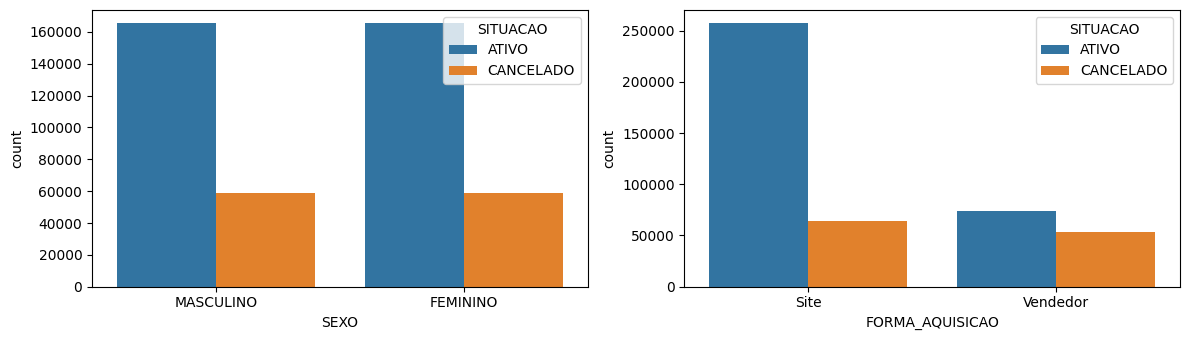

In [15]:
# Analisando o gráfico da variavel ['FORMA_AQUISICAO'] e ['SEXO'] comparadas a variável ALVO
plt.rcParams["figure.figsize"] = [12.00, 3.50]
plt.rcParams["figure.autolayout"] = True
f, axes = plt.subplots(1, 2)
sns.countplot(data = dados, x = "SEXO", hue = "SITUACAO", ax=axes[0])
sns.countplot(data = dados, x = "FORMA_AQUISICAO", hue = "SITUACAO", ax=axes[1])
plt.show()

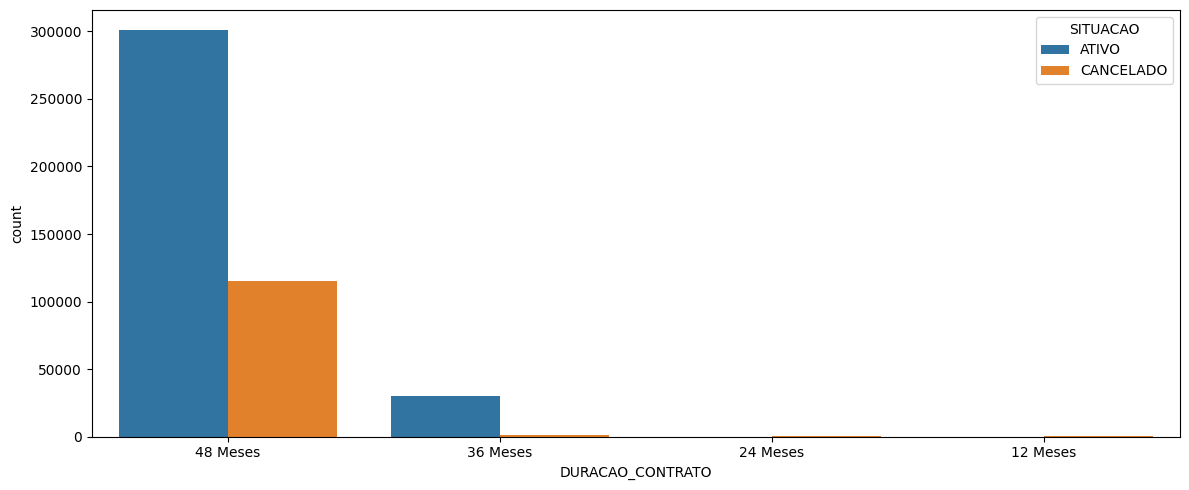

In [16]:
# Analisando o gráfico da variavel ['DURACAO_CONTRATO'] comparadas a variável ALVO
plt.rcParams["figure.figsize"] = [12.00, 5.00]
plt.rcParams["figure.autolayout"] = True
sns.countplot(data = dados, x = "DURACAO_CONTRATO", hue = "SITUACAO")
plt.show()

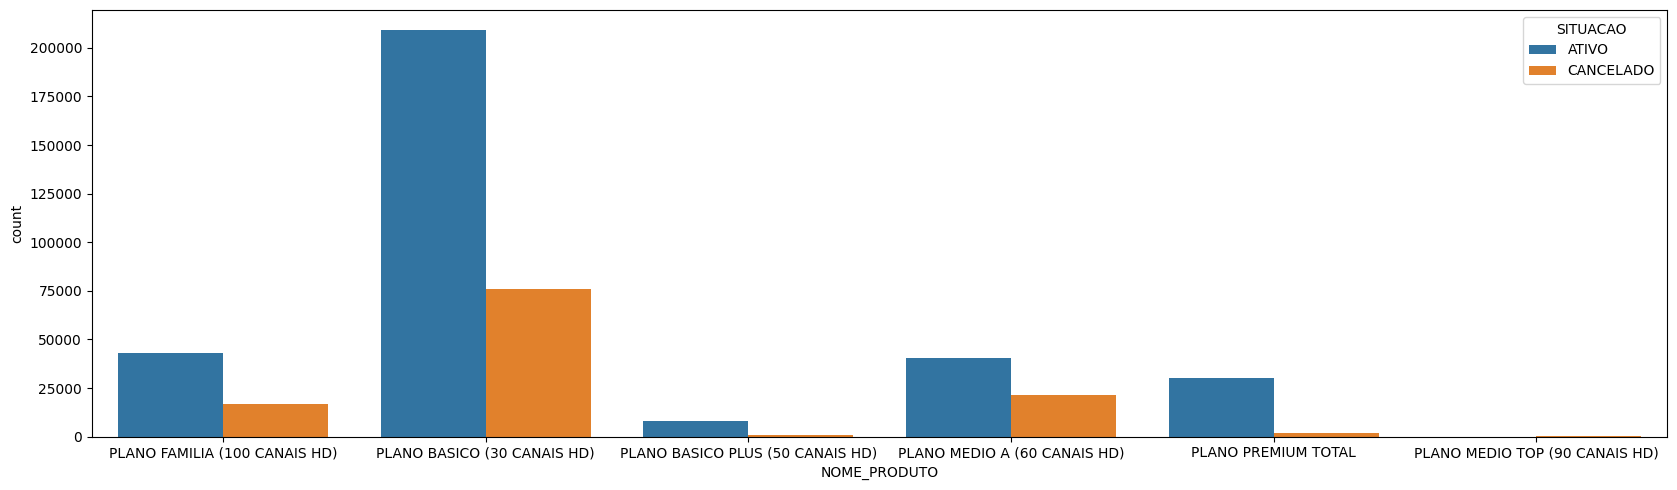

In [17]:
# Analisando o gráfico da variavel ['NOME_PRODUTO'] comparadas a variável ALVO
plt.rcParams["figure.figsize"] = [17.00, 5.00]
plt.rcParams["figure.autolayout"] = True
sns.countplot(data = dados, x = "NOME_PRODUTO", hue = "SITUACAO")
plt.show()

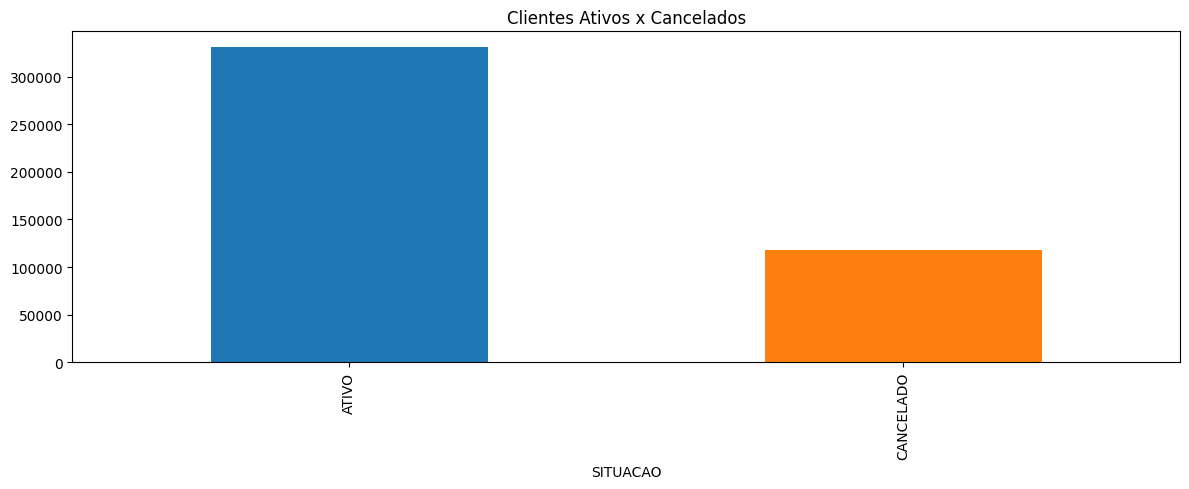

In [18]:
#Analisando como a variavel alvo está distribuida.
plt.rcParams["figure.figsize"] = [12.00, 5.00]
plt.rcParams["figure.autolayout"] = True
dados.SITUACAO.value_counts().plot(kind='bar', title='Clientes Ativos x Cancelados',color = ['#1F77B4', '#FF7F0E']);

In [20]:
# Carregando variaveis para plot
# Pegaremos a partir da variavel 1 porque o ['ID_CLIENTE'] não iremos utilizar
variaveis_numericas = [] # Lista vazia
for i in dados.columns[1:24].tolist(): # Fazemos um loop for da variável 1 até a 24
        if dados.dtypes[i] == 'int64' or dados.dtypes[i] == 'float64': # se o dataframe for igual a int64 ou float64 é numérico
            print(i, ':' , dados.dtypes[i]) # Mostra o nome da variável
            variaveis_numericas.append(i)    # Inclui a variável na lista

IDADE_CLIENTE : int64
QT_FILHOS : float64
DIAS_ATIVO : int64
MESES_ATIVO : int64
VL_PLANO_ADESAO : int64
VL_PLANO_ATUAL : int64
QT_PONTOS_INSTALADOS : int64
QT_PC_PAGAS : int64
QT_PC_VENCIDAS : int64
QT_PC_PAGA_ATRASO : int64
QT_PC_PAGA_EM_DIA : int64
QT_ACORDO_PAGAMENTO : int64
VL_MENSALIDADE_ATRASO : int64
VL_MENSALIDADE_DT_AQUISICAO : int64
VL_MENSALIDADE_DT_ATUAL : int64
COD_SITUACAO : int64


In [21]:
# Observando a quantidade de variáveis
len(variaveis_numericas)

16

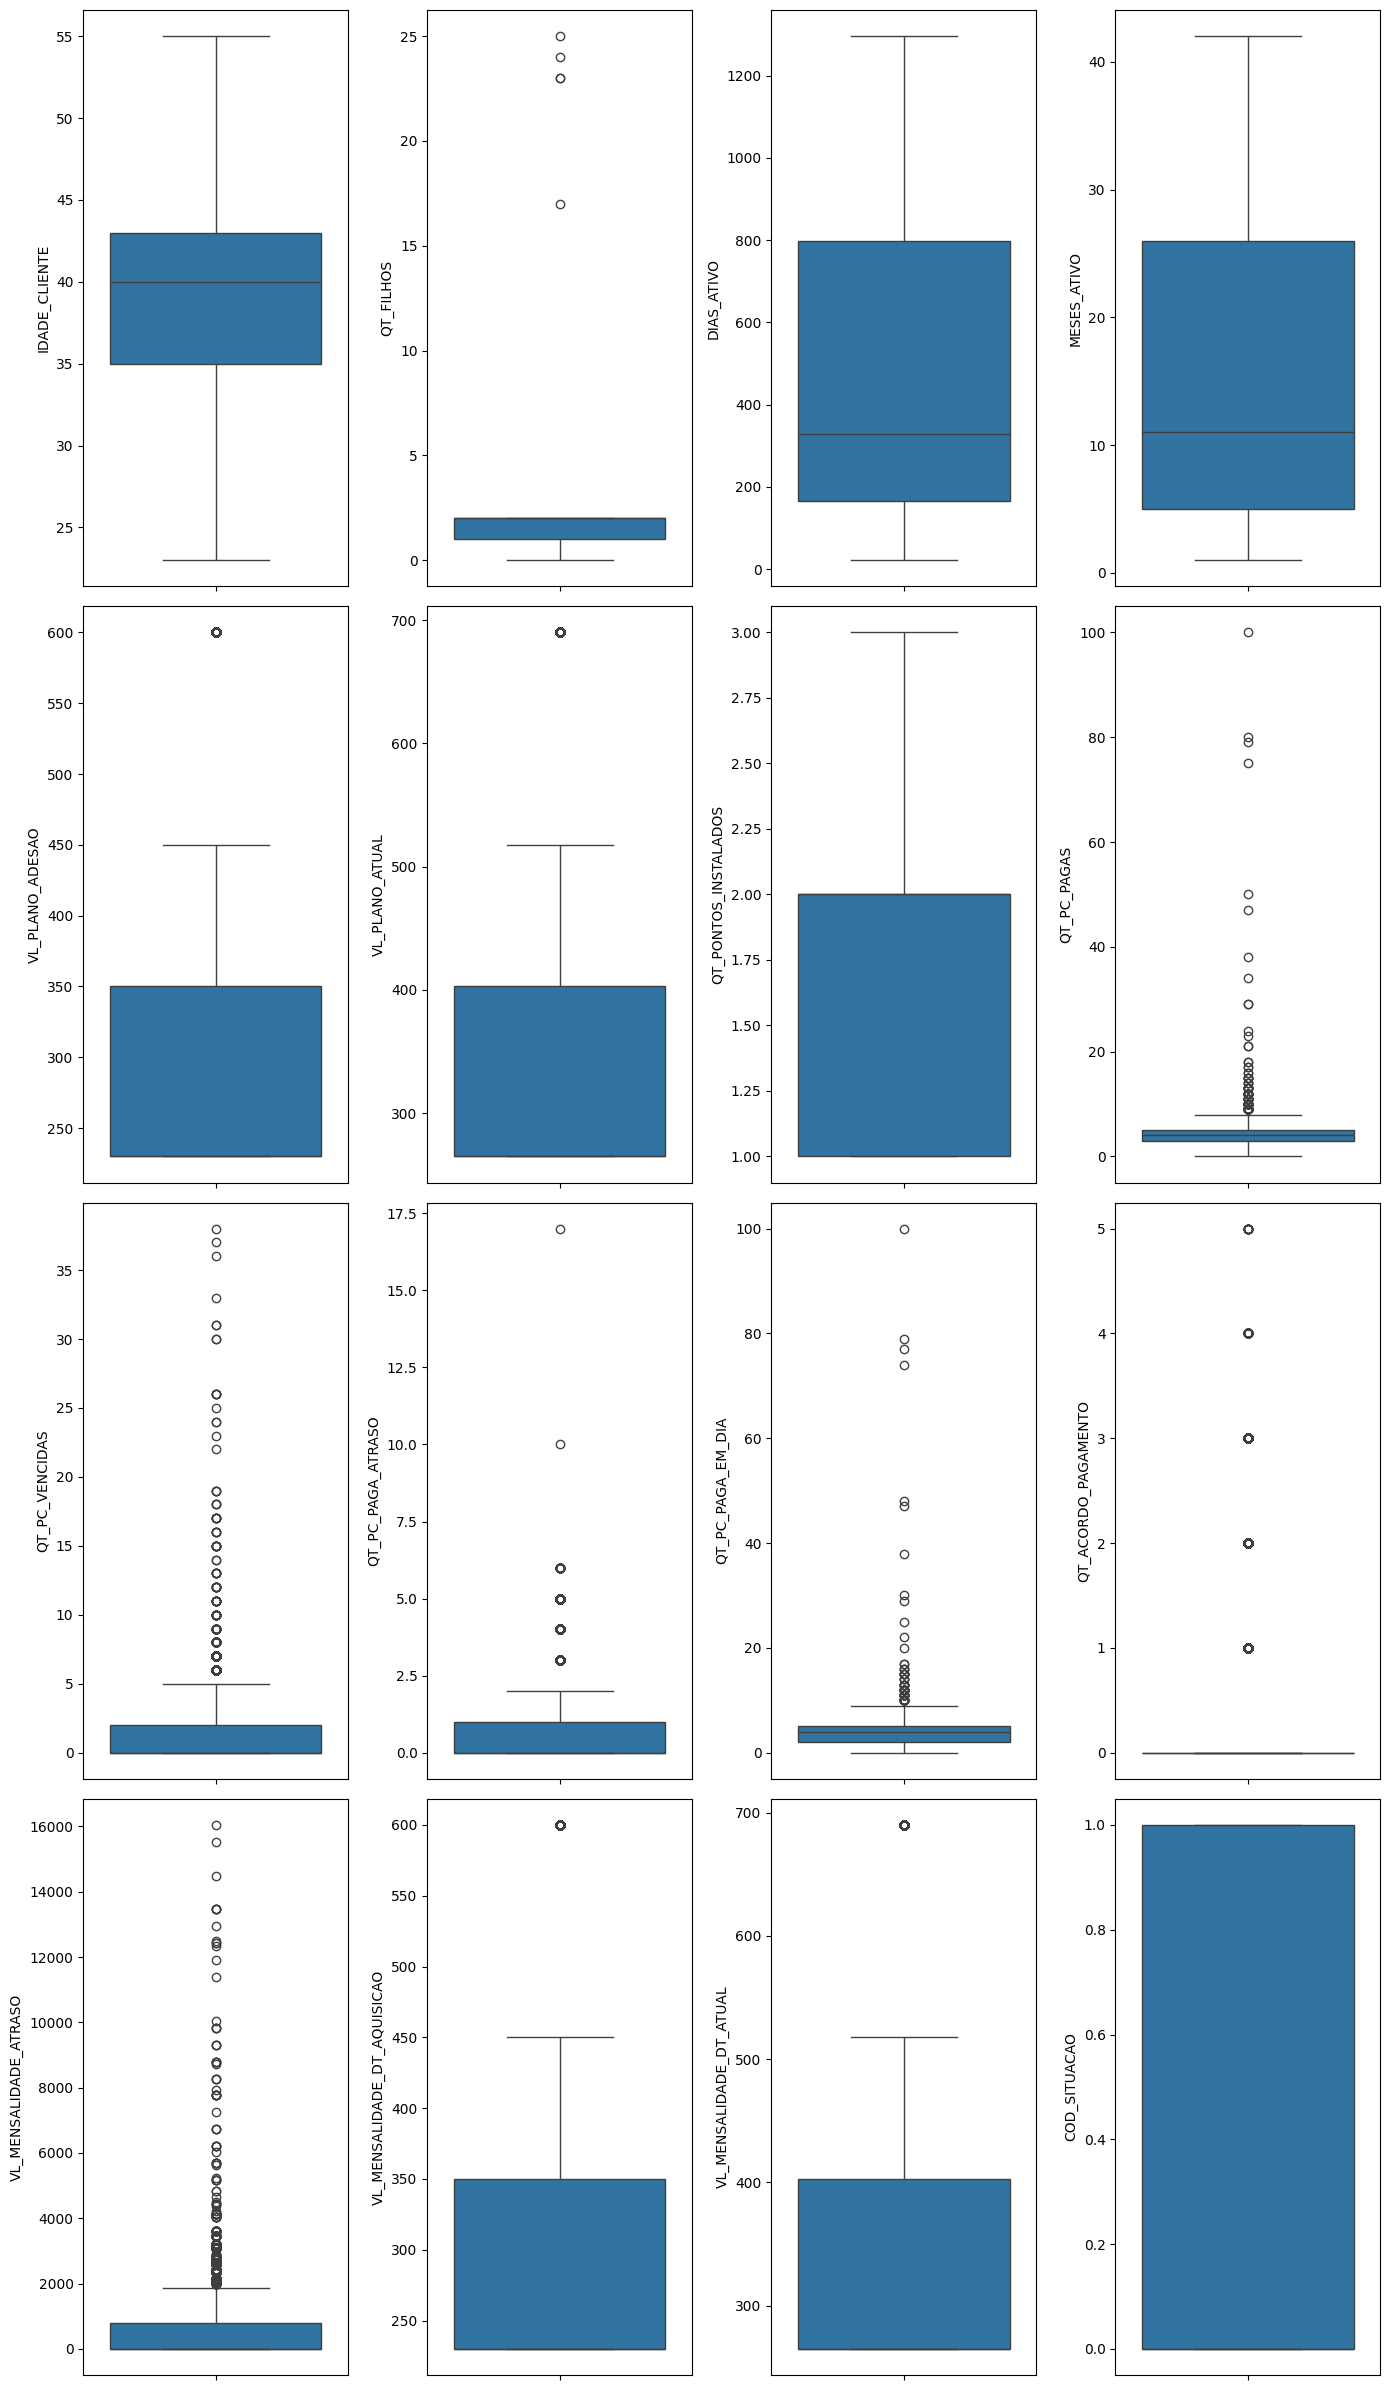

In [22]:
# Observando através de boxplot
plt.rcParams["figure.figsize"] = [14.00, 24.00] # Tamanho dos gráficos
plt.rcParams["figure.autolayout"] = True
f, axes = plt.subplots(4, 4) #4 linhas e 4 colunas

linha = 0 # contador de linha iniciando de 0
coluna = 0 # contador de coluna iniciando de 0
for i in variaveis_numericas: # Loop for para cada variável
    sns.boxplot(data = dados, y=i, ax=axes[linha][coluna]) # Com o seaborn e o boxplot, passamos o dataframe, y=i o contador, axi=axes são os eixos
    coluna += 1
    if coluna == 4:
        linha += 1
        coluna = 0

plt.show()

In [23]:
# Vamos excluir os 5 registros da variável ['QT_FILHOS'] porque são poucos
dados.groupby(['QT_FILHOS']).size()

QT_FILHOS
0.0         10
1.0     212353
2.0     235825
17.0         1
23.0         2
24.0         1
25.0         1
dtype: int64

In [25]:
# Aqui podemos ver os registros...
dados.loc[dados['QT_FILHOS'] > 2]

,ID_CLIENTE,FORMA_AQUISICAO,IDADE_CLIENTE,SEXO,QT_FILHOS,DT_AQUISICAO,DT_CANCELAMENTO,DIAS_ATIVO,MESES_ATIVO,DURACAO_CONTRATO,VL_PLANO_ADESAO,VL_PLANO_ATUAL,NOME_PRODUTO,QT_PONTOS_INSTALADOS,QT_PC_PAGAS,QT_PC_VENCIDAS,QT_PC_PAGA_ATRASO,QT_PC_PAGA_EM_DIA,QT_ACORDO_PAGAMENTO,VL_MENSALIDADE_ATRASO,VL_MENSALIDADE_DT_AQUISICAO,VL_MENSALIDADE_DT_ATUAL,SITUACAO,COD_SITUACAO
3,4,Vendedor,26,FEMININO,17.0,25/06/2019,NaN,757,25,48 Meses,230,265,PLANO BASICO (30 CANAIS HD),1,5,0,1,4,0,0,230,265,ATIVO,0
91,92,Vendedor,48,FEMININO,23.0,03/08/2018,NaN,1083,35,48 Meses,230,265,PLANO BASICO (30 CANAIS HD),2,5,0,1,4,0,0,230,265,ATIVO,0
164,165,Vendedor,55,MASCULINO,23.0,19/06/2018,NaN,1128,37,48 Meses,230,265,PLANO BASICO (30 CANAIS HD),3,5,0,2,3,1,0,230,265,ATIVO,0
273,274,Vendedor,32,FEMININO,24.0,02/05/2018,NaN,1176,38,48 Meses,230,265,PLANO BASICO (30 CANAIS HD),1,5,0,2,3,1,0,230,265,ATIVO,0
454,455,Vendedor,38,MASCULINO,25.0,04/09/2018,NaN,1051,34,48 Meses,230,265,PLANO BASICO (30 CANAIS HD),2,5,0,1,4,1,0,230,265,ATIVO,0


In [26]:
# Manteremos o DataFrame dados e os dados tratados ficarão no DataFrame chamado df_dados
df_dados = dados.loc[dados['QT_FILHOS'] <= 2]
df_dados.shape

(448188, 24)

In [27]:
# Confirmando se a exclusão foi feita
df_dados.groupby(['QT_FILHOS']).size()

QT_FILHOS
0.0        10
1.0    212353
2.0    235825
dtype: int64

In [28]:
# Conferindo a média, mediana e a moda da variável 'QT_FILHOS'
print('Média de Filhos: ', df_dados['QT_FILHOS'].mean())
print('Mediana de Filhos: ',df_dados['QT_FILHOS'].median())
print('Moda: ', df_dados['QT_FILHOS'].mode())

Média de Filhos:  1.5261519719403465
Mediana de Filhos:  2.0
Moda:  0    2.0
Name: QT_FILHOS, dtype: float64


In [29]:
# Preencheremos os valores NULOS com a mediana dos dados
df_dados['QT_FILHOS'] = df_dados['QT_FILHOS'].fillna((df_dados['QT_FILHOS'].median()))
df_dados.isnull().sum()

ID_CLIENTE                          0
FORMA_AQUISICAO                     0
IDADE_CLIENTE                       0
SEXO                                0
QT_FILHOS                           0
DT_AQUISICAO                        0
DT_CANCELAMENTO                330987
DIAS_ATIVO                          0
MESES_ATIVO                         0
DURACAO_CONTRATO                    0
VL_PLANO_ADESAO                     0
VL_PLANO_ATUAL                      0
NOME_PRODUTO                        0
QT_PONTOS_INSTALADOS                0
QT_PC_PAGAS                         0
QT_PC_VENCIDAS                      0
QT_PC_PAGA_ATRASO                   0
QT_PC_PAGA_EM_DIA                   0
QT_ACORDO_PAGAMENTO                 0
VL_MENSALIDADE_ATRASO               0
VL_MENSALIDADE_DT_AQUISICAO         0
VL_MENSALIDADE_DT_ATUAL             0
SITUACAO                            0
COD_SITUACAO                        0
dtype: int64

In [30]:
# Substituindo os dados da variavel ['DURACAO_CONTRATO'] para mantermos somente os números
df_dados['DURACAO_CONTRATO'] = df_dados['DURACAO_CONTRATO'].replace(['12 Meses'], 12)
df_dados['DURACAO_CONTRATO'] = df_dados['DURACAO_CONTRATO'].replace(['24 Meses'], 24)
df_dados['DURACAO_CONTRATO'] = df_dados['DURACAO_CONTRATO'].replace(['36 Meses'], 36)
df_dados['DURACAO_CONTRATO'] = df_dados['DURACAO_CONTRATO'].replace(['48 Meses'], 48)

In [31]:
# Visualizando as primeiras linhas
df_dados.head()

,ID_CLIENTE,FORMA_AQUISICAO,IDADE_CLIENTE,SEXO,QT_FILHOS,DT_AQUISICAO,DT_CANCELAMENTO,DIAS_ATIVO,MESES_ATIVO,DURACAO_CONTRATO,VL_PLANO_ADESAO,VL_PLANO_ATUAL,NOME_PRODUTO,QT_PONTOS_INSTALADOS,QT_PC_PAGAS,QT_PC_VENCIDAS,QT_PC_PAGA_ATRASO,QT_PC_PAGA_EM_DIA,QT_ACORDO_PAGAMENTO,VL_MENSALIDADE_ATRASO,VL_MENSALIDADE_DT_AQUISICAO,VL_MENSALIDADE_DT_ATUAL,SITUACAO,COD_SITUACAO
0,1,Site,23,MASCULINO,0.0,18/06/2021,NaN,33,1,48,450,518,PLANO FAMILIA (100 CANAIS HD),1,1,4,0,1,1,2070,450,518,ATIVO,0
1,2,Vendedor,24,FEMININO,0.0,10/04/2018,NaN,1198,39,48,230,265,PLANO BASICO (30 CANAIS HD),2,5,0,1,4,0,0,230,265,ATIVO,0
2,3,Site,25,MASCULINO,0.0,09/10/2020,NaN,285,9,48,290,334,PLANO BASICO PLUS (50 CANAIS HD),3,5,0,3,2,0,0,290,334,ATIVO,0
4,5,Vendedor,27,MASCULINO,0.0,19/09/2019,NaN,671,22,48,230,265,PLANO BASICO (30 CANAIS HD),2,5,0,5,0,0,0,230,265,ATIVO,0
5,6,Vendedor,28,FEMININO,1.0,23/03/2018,NaN,1216,40,48,230,265,PLANO BASICO (30 CANAIS HD),3,5,0,0,5,0,0,230,265,ATIVO,0


In [32]:
# Visualizando as informações dos tipos de variaveis
df_dados.info()

<class 'pandas.core.frame.DataFrame'>
Index: 448188 entries, 0 to 448446
Data columns (total 24 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   ID_CLIENTE                   448188 non-null  int64  
 1   FORMA_AQUISICAO              448188 non-null  object 
 2   IDADE_CLIENTE                448188 non-null  int64  
 3   SEXO                         448188 non-null  object 
 4   QT_FILHOS                    448188 non-null  float64
 5   DT_AQUISICAO                 448188 non-null  object 
 6   DT_CANCELAMENTO              117201 non-null  object 
 7   DIAS_ATIVO                   448188 non-null  int64  
 8   MESES_ATIVO                  448188 non-null  int64  
 9   DURACAO_CONTRATO             448188 non-null  int64  
 10  VL_PLANO_ADESAO              448188 non-null  int64  
 11  VL_PLANO_ATUAL               448188 non-null  int64  
 12  NOME_PRODUTO                 448188 non-null  object 
 13  QT_P

In [33]:
# Identificando as quantidades máximas para tratar os OUTLIERS
print(df_dados['QT_PC_PAGAS'].max())
print(df_dados['QT_PC_PAGA_EM_DIA'].max())

100
100


In [34]:
# Alterando os registros para os valores corretos
df_dados.loc[df_dados.QT_PC_PAGAS > df_dados.DURACAO_CONTRATO, 'QT_PC_PAGAS'] = df_dados.DURACAO_CONTRATO
df_dados.loc[df_dados.QT_PC_PAGA_EM_DIA > df_dados.DURACAO_CONTRATO, 'QT_PC_PAGA_EM_DIA'] = df_dados.DURACAO_CONTRATO

In [35]:
# Verificando se as variáveis foram ajustadas
print(df_dados['QT_PC_PAGAS'].max())
print(df_dados['QT_PC_PAGA_EM_DIA'].max())

48
48


In [36]:
# Engenharia de Atributos
bins = [-100, 3, 6, 12, 48]
labels = ['RUIM', 'MEDIO', 'BOM', 'OTIMO']
df_dados['NIVEL_PAGAMENTO'] = pd.cut(df_dados['QT_PC_PAGAS'], bins=bins, labels=labels)
pd.value_counts(df_dados.NIVEL_PAGAMENTO)

NIVEL_PAGAMENTO
MEDIO    297750
RUIM     149912
BOM         488
OTIMO        38
Name: count, dtype: int64

In [37]:
# Observando
df_dados.head()

,ID_CLIENTE,FORMA_AQUISICAO,IDADE_CLIENTE,SEXO,QT_FILHOS,DT_AQUISICAO,DT_CANCELAMENTO,DIAS_ATIVO,MESES_ATIVO,DURACAO_CONTRATO,VL_PLANO_ADESAO,VL_PLANO_ATUAL,NOME_PRODUTO,QT_PONTOS_INSTALADOS,QT_PC_PAGAS,QT_PC_VENCIDAS,QT_PC_PAGA_ATRASO,QT_PC_PAGA_EM_DIA,QT_ACORDO_PAGAMENTO,VL_MENSALIDADE_ATRASO,VL_MENSALIDADE_DT_AQUISICAO,VL_MENSALIDADE_DT_ATUAL,SITUACAO,COD_SITUACAO,NIVEL_PAGAMENTO
0,1,Site,23,MASCULINO,0.0,18/06/2021,NaN,33,1,48,450,518,PLANO FAMILIA (100 CANAIS HD),1,1,4,0,1,1,2070,450,518,ATIVO,0,RUIM
1,2,Vendedor,24,FEMININO,0.0,10/04/2018,NaN,1198,39,48,230,265,PLANO BASICO (30 CANAIS HD),2,5,0,1,4,0,0,230,265,ATIVO,0,MEDIO
2,3,Site,25,MASCULINO,0.0,09/10/2020,NaN,285,9,48,290,334,PLANO BASICO PLUS (50 CANAIS HD),3,5,0,3,2,0,0,290,334,ATIVO,0,MEDIO
4,5,Vendedor,27,MASCULINO,0.0,19/09/2019,NaN,671,22,48,230,265,PLANO BASICO (30 CANAIS HD),2,5,0,5,0,0,0,230,265,ATIVO,0,MEDIO
5,6,Vendedor,28,FEMININO,1.0,23/03/2018,NaN,1216,40,48,230,265,PLANO BASICO (30 CANAIS HD),3,5,0,0,5,0,0,230,265,ATIVO,0,MEDIO


In [38]:
# Fazendo uma cópia do DataFrame com as modificações
df_dados_2 = df_dados.copy()
df_dados_2.head()

,ID_CLIENTE,FORMA_AQUISICAO,IDADE_CLIENTE,SEXO,QT_FILHOS,DT_AQUISICAO,DT_CANCELAMENTO,DIAS_ATIVO,MESES_ATIVO,DURACAO_CONTRATO,VL_PLANO_ADESAO,VL_PLANO_ATUAL,NOME_PRODUTO,QT_PONTOS_INSTALADOS,QT_PC_PAGAS,QT_PC_VENCIDAS,QT_PC_PAGA_ATRASO,QT_PC_PAGA_EM_DIA,QT_ACORDO_PAGAMENTO,VL_MENSALIDADE_ATRASO,VL_MENSALIDADE_DT_AQUISICAO,VL_MENSALIDADE_DT_ATUAL,SITUACAO,COD_SITUACAO,NIVEL_PAGAMENTO
0,1,Site,23,MASCULINO,0.0,18/06/2021,NaN,33,1,48,450,518,PLANO FAMILIA (100 CANAIS HD),1,1,4,0,1,1,2070,450,518,ATIVO,0,RUIM
1,2,Vendedor,24,FEMININO,0.0,10/04/2018,NaN,1198,39,48,230,265,PLANO BASICO (30 CANAIS HD),2,5,0,1,4,0,0,230,265,ATIVO,0,MEDIO
2,3,Site,25,MASCULINO,0.0,09/10/2020,NaN,285,9,48,290,334,PLANO BASICO PLUS (50 CANAIS HD),3,5,0,3,2,0,0,290,334,ATIVO,0,MEDIO
4,5,Vendedor,27,MASCULINO,0.0,19/09/2019,NaN,671,22,48,230,265,PLANO BASICO (30 CANAIS HD),2,5,0,5,0,0,0,230,265,ATIVO,0,MEDIO
5,6,Vendedor,28,FEMININO,1.0,23/03/2018,NaN,1216,40,48,230,265,PLANO BASICO (30 CANAIS HD),3,5,0,0,5,0,0,230,265,ATIVO,0,MEDIO


In [39]:
# Criando o encoder
lb = LabelEncoder()
df_dados_2['SEXO'] = lb.fit_transform(df_dados_2['SEXO'])
df_dados_2['FORMA_AQUISICAO'] = lb.fit_transform(df_dados_2['FORMA_AQUISICAO'])
df_dados_2['NOME_PRODUTO'] = lb.fit_transform(df_dados_2['NOME_PRODUTO'])
df_dados_2['NIVEL_PAGAMENTO'] = lb.fit_transform(df_dados_2['NIVEL_PAGAMENTO'])

In [40]:
# Visualizando
df_dados_2.head()

,ID_CLIENTE,FORMA_AQUISICAO,IDADE_CLIENTE,SEXO,QT_FILHOS,DT_AQUISICAO,DT_CANCELAMENTO,DIAS_ATIVO,MESES_ATIVO,DURACAO_CONTRATO,VL_PLANO_ADESAO,VL_PLANO_ATUAL,NOME_PRODUTO,QT_PONTOS_INSTALADOS,QT_PC_PAGAS,QT_PC_VENCIDAS,QT_PC_PAGA_ATRASO,QT_PC_PAGA_EM_DIA,QT_ACORDO_PAGAMENTO,VL_MENSALIDADE_ATRASO,VL_MENSALIDADE_DT_AQUISICAO,VL_MENSALIDADE_DT_ATUAL,SITUACAO,COD_SITUACAO,NIVEL_PAGAMENTO
0,1,0,23,1,0.0,18/06/2021,NaN,33,1,48,450,518,2,1,1,4,0,1,1,2070,450,518,ATIVO,0,3
1,2,1,24,0,0.0,10/04/2018,NaN,1198,39,48,230,265,0,2,5,0,1,4,0,0,230,265,ATIVO,0,1
2,3,0,25,1,0.0,09/10/2020,NaN,285,9,48,290,334,1,3,5,0,3,2,0,0,290,334,ATIVO,0,1
4,5,1,27,1,0.0,19/09/2019,NaN,671,22,48,230,265,0,2,5,0,5,0,0,0,230,265,ATIVO,0,1
5,6,1,28,0,1.0,23/03/2018,NaN,1216,40,48,230,265,0,3,5,0,0,5,0,0,230,265,ATIVO,0,1


In [41]:
#Listando as colunas
df_dados_2.columns.tolist()

['ID_CLIENTE',
 'FORMA_AQUISICAO',
 'IDADE_CLIENTE',
 'SEXO',
 'QT_FILHOS',
 'DT_AQUISICAO',
 'DT_CANCELAMENTO',
 'DIAS_ATIVO',
 'MESES_ATIVO',
 'DURACAO_CONTRATO',
 'VL_PLANO_ADESAO',
 'VL_PLANO_ATUAL',
 'NOME_PRODUTO',
 'QT_PONTOS_INSTALADOS',
 'QT_PC_PAGAS',
 'QT_PC_VENCIDAS',
 'QT_PC_PAGA_ATRASO',
 'QT_PC_PAGA_EM_DIA',
 'QT_ACORDO_PAGAMENTO',
 'VL_MENSALIDADE_ATRASO',
 'VL_MENSALIDADE_DT_AQUISICAO',
 'VL_MENSALIDADE_DT_ATUAL',
 'SITUACAO',
 'COD_SITUACAO',
 'NIVEL_PAGAMENTO']

In [42]:
# Filtrando para utilizar somente as colunas necessárias
columns = ['FORMA_AQUISICAO',
 'IDADE_CLIENTE',
 'SEXO',
 'QT_FILHOS',
 'DIAS_ATIVO',
 'MESES_ATIVO',
 'DURACAO_CONTRATO',
 'VL_PLANO_ADESAO',
 'VL_PLANO_ATUAL',
 'NOME_PRODUTO',
 'QT_PONTOS_INSTALADOS',
 'QT_PC_PAGAS',
 'QT_PC_VENCIDAS',
 'QT_PC_PAGA_ATRASO',
 'QT_PC_PAGA_EM_DIA',
 'QT_ACORDO_PAGAMENTO',
 'VL_MENSALIDADE_ATRASO',
 'VL_MENSALIDADE_DT_AQUISICAO',
 'VL_MENSALIDADE_DT_ATUAL',
 'NIVEL_PAGAMENTO',
 'COD_SITUACAO']

df_dados_2 = pd.DataFrame(df_dados_2, columns=columns)

In [43]:
# Visualizando as primeiras linhas do arquivo novamente
df_dados_2.head()

,FORMA_AQUISICAO,IDADE_CLIENTE,SEXO,QT_FILHOS,DIAS_ATIVO,MESES_ATIVO,DURACAO_CONTRATO,VL_PLANO_ADESAO,VL_PLANO_ATUAL,NOME_PRODUTO,QT_PONTOS_INSTALADOS,QT_PC_PAGAS,QT_PC_VENCIDAS,QT_PC_PAGA_ATRASO,QT_PC_PAGA_EM_DIA,QT_ACORDO_PAGAMENTO,VL_MENSALIDADE_ATRASO,VL_MENSALIDADE_DT_AQUISICAO,VL_MENSALIDADE_DT_ATUAL,NIVEL_PAGAMENTO,COD_SITUACAO
0,0,23,1,0.0,33,1,48,450,518,2,1,1,4,0,1,1,2070,450,518,3,0
1,1,24,0,0.0,1198,39,48,230,265,0,2,5,0,1,4,0,0,230,265,1,0
2,0,25,1,0.0,285,9,48,290,334,1,3,5,0,3,2,0,0,290,334,1,0
4,1,27,1,0.0,671,22,48,230,265,0,2,5,0,5,0,0,0,230,265,1,0
5,1,28,0,1.0,1216,40,48,230,265,0,3,5,0,0,5,0,0,230,265,1,0


In [44]:
# Verificando os tipos de variáveis
df_dados_2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 448188 entries, 0 to 448446
Data columns (total 21 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   FORMA_AQUISICAO              448188 non-null  int64  
 1   IDADE_CLIENTE                448188 non-null  int64  
 2   SEXO                         448188 non-null  int64  
 3   QT_FILHOS                    448188 non-null  float64
 4   DIAS_ATIVO                   448188 non-null  int64  
 5   MESES_ATIVO                  448188 non-null  int64  
 6   DURACAO_CONTRATO             448188 non-null  int64  
 7   VL_PLANO_ADESAO              448188 non-null  int64  
 8   VL_PLANO_ATUAL               448188 non-null  int64  
 9   NOME_PRODUTO                 448188 non-null  int64  
 10  QT_PONTOS_INSTALADOS         448188 non-null  int64  
 11  QT_PC_PAGAS                  448188 non-null  int64  
 12  QT_PC_VENCIDAS               448188 non-null  int64  
 13  QT_P

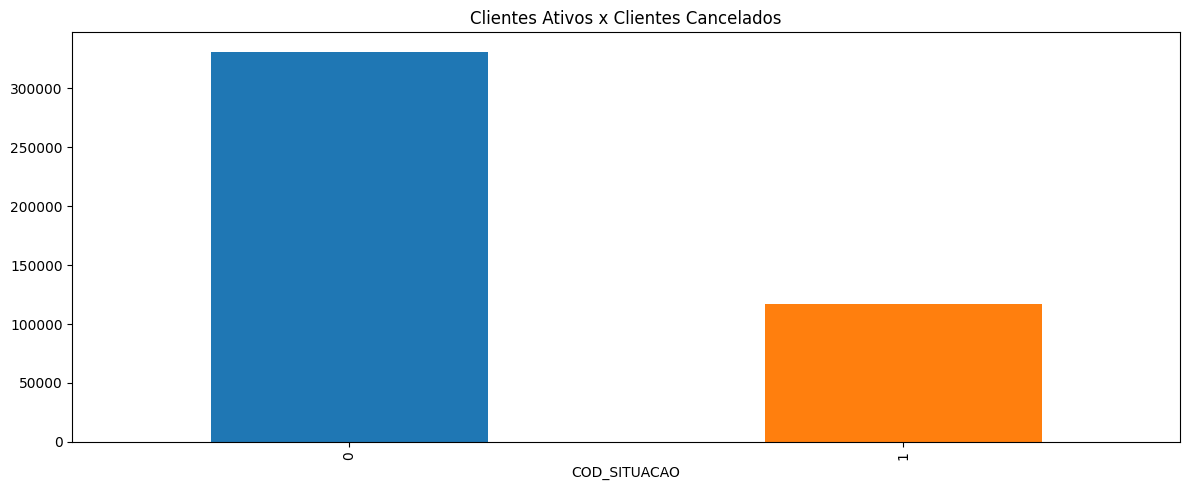

In [45]:
#Analisando como a variavel alvo está distribuida.
plt.rcParams["figure.figsize"] = [12.00, 5.00]
plt.rcParams["figure.autolayout"] = True
df_dados_2.COD_SITUACAO.value_counts().plot(kind='bar', title='Clientes Ativos x Clientes Cancelados',color = ['#1F77B4', '#FF7F0E']);

In [47]:
# Separarando as variaveis preditoras e target
preditoras = df_dados_2.iloc[:, 0:20]   # Vamos pegar da coluna 0 até a 20 e salvar como preditoras
target = df_dados_2.iloc[:, 20]  # Aqui vamos peagr somente a variável 20 [COD_SITUACAO]

In [48]:
# Observando
preditoras.head()

,FORMA_AQUISICAO,IDADE_CLIENTE,SEXO,QT_FILHOS,DIAS_ATIVO,MESES_ATIVO,DURACAO_CONTRATO,VL_PLANO_ADESAO,VL_PLANO_ATUAL,NOME_PRODUTO,QT_PONTOS_INSTALADOS,QT_PC_PAGAS,QT_PC_VENCIDAS,QT_PC_PAGA_ATRASO,QT_PC_PAGA_EM_DIA,QT_ACORDO_PAGAMENTO,VL_MENSALIDADE_ATRASO,VL_MENSALIDADE_DT_AQUISICAO,VL_MENSALIDADE_DT_ATUAL,NIVEL_PAGAMENTO
0,0,23,1,0.0,33,1,48,450,518,2,1,1,4,0,1,1,2070,450,518,3
1,1,24,0,0.0,1198,39,48,230,265,0,2,5,0,1,4,0,0,230,265,1
2,0,25,1,0.0,285,9,48,290,334,1,3,5,0,3,2,0,0,290,334,1
4,1,27,1,0.0,671,22,48,230,265,0,2,5,0,5,0,0,0,230,265,1
5,1,28,0,1.0,1216,40,48,230,265,0,3,5,0,0,5,0,0,230,265,1


In [49]:
# Observando a target
target.head()

0    0
1    0
2    0
4    0
5    0
Name: COD_SITUACAO, dtype: int64

In [50]:
# Criando o balanceador
balanceador = SMOTE()

In [51]:
# Aplicando o balanceador
preditoras_res, target_res = balanceador.fit_resample(preditoras, target)

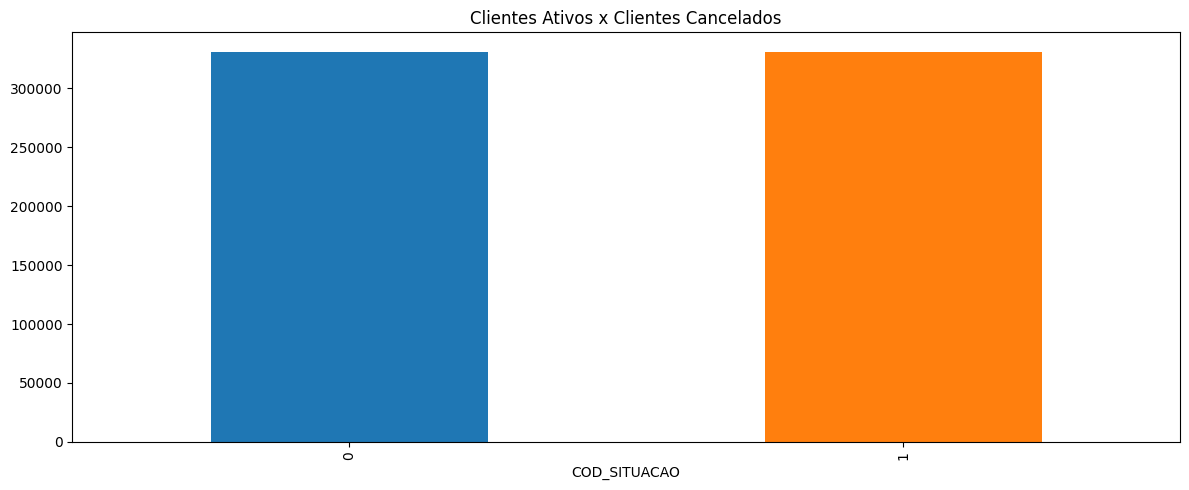

In [53]:
# Visualizando o balanceamento da variável target
plt.rcParams["figure.figsize"] = [12.00, 5.00]
plt.rcParams["figure.autolayout"] = True
target_res.value_counts().plot(kind='bar', title='Clientes Ativos x Clientes Cancelados',color = ['#1F77B4', '#FF7F0E']);

In [54]:
# Quantidade de registros antes do balanceamento
preditoras.shape

(448188, 20)

In [55]:
# Quantidade de registros antes do balanceamento
target.shape

(448188,)

In [56]:
# Quantidade de registros após do balanceamento
preditoras_res.shape

(661974, 20)

In [57]:
# Quantidade de registros após do balanceamento
target_res.shape

(661974,)

In [59]:
# Divisão em base de treino e teste
x_treino, x_teste, y_treino, y_teste = train_test_split(preditoras_res, target_res, test_size = 0.3)

In [60]:
# Padronizando as Variáveis
padronizador = StandardScaler()
x_treino_padronizados = padronizador.fit_transform(x_treino)
x_teste_padronizados = padronizador.transform(x_teste)

In [61]:
# Visualizando os dados padronizados
x_treino_padronizados

array([[-0.69340126,  0.53314319, -0.94357435, ..., -0.64823736,
        -0.64841465,  1.05372941],
       [-0.69340126, -0.02516149,  1.0597999 , ..., -0.64823736,
        -0.64841465,  1.05372941],
       [-0.69340126, -1.56049936,  1.0597999 , ..., -0.64823736,
        -0.64841465,  1.05372941],
       ...,
       [-0.69340126,  0.67271936,  1.0597999 , ...,  1.41181299,
         1.41290825, -0.94759115],
       [-0.69340126, -0.72304234,  1.0597999 , ...,  0.47542647,
         0.4759433 ,  1.05372941],
       [ 1.44216641,  0.53314319, -0.94357435, ...,  0.47542647,
         0.4759433 ,  1.05372941]])

In [62]:
# Range de valores de k que iremos testar
kVals = range(3, 10, 2)

In [63]:
# Lista vazia para receber as acurácias
acuracias = []

In [65]:
start = time.time()
for k in kVals:

    # Treinando o modelo KNN com cada valor de k
    modeloKNN = KNeighborsClassifier(n_neighbors = k)
    modeloKNN.fit(x_treino_padronizados, y_treino)

    # Avaliando o modelo e atualizando a lista de acurácias
    score = modeloKNN.score(x_teste_padronizados, y_teste)
    print("Com valor de k = %d, a acurácia é = %.2f%%" % (k, score * 100))
    acuracias.append(score)
end = time.time()
print('Tempo de Treinamento do Modelo:', end - start)

Com valor de k = 3, a acurácia é = 97.71%
Com valor de k = 5, a acurácia é = 97.45%
Com valor de k = 7, a acurácia é = 97.23%
Com valor de k = 9, a acurácia é = 97.05%
Tempo de Treinamento do Modelo: 2137.837935447693


In [66]:
# Obtendo o valor de k que apresentou a maior acurácia
i = np.argmax(acuracias)
print("O valor de k = %d alcançou a mais alta acurácia de %.2f%% nos dados de validação!" % (kVals[i],
                                                                                             acuracias[i] * 100))

O valor de k = 3 alcançou a mais alta acurácia de 97.71% nos dados de validação!


In [67]:
# Criando a versão final do modelo com o maior valor de k
modeloFinal = KNeighborsClassifier(n_neighbors = kVals[i])

In [68]:
# Treinamento do modelo
modeloFinal.fit(x_treino_padronizados, y_treino)

KNeighborsClassifier(n_neighbors=3)

In [69]:
# Previsões com os dados de teste
previsoes = modeloFinal.predict(x_teste_padronizados)

In [71]:
print('Acurácia do modelo: ' , accuracy_score(y_teste, previsoes))

Acurácia do modelo:  0.9771139969686746
